In [37]:
! pip install -r requirements.txt

2978.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## API Keys

In [38]:
# set your API keys in the .env file..
import os
from dotenv import load_dotenv

load_dotenv()

assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY is not set"
assert os.getenv("LANGCHAIN_API_KEY"), "LANGCHAIN_API_KEY is not set"


## Tracability

In [39]:
from langchain.callbacks.tracers.langchain import LangChainTracer

tracer = LangChainTracer()

## System Prompts

In [40]:
from langchain_core.messages import SystemMessage

t="""Return a comma separated list of exactly 5 valid YouTube video IDs 
that are most relevant to the user's query.
For example: 'id1,id2,id3,id4,id5'"""

sp1=SystemMessage(content=t)

sp2=SystemMessage(content="Use the context below to answer the question.")

## LLM

In [41]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage

# create the LLM
llm = ChatOpenAI(
    model="gpt-4o", 
    temperature=0,
    callbacks=[tracer]
    )

prompt_videos = ChatPromptTemplate.from_messages([
    ("system", """Return a comma separated list of exactly 5 valid YouTube video IDs that are most 
                  relevant to the user's query. 
                  For example: 'id1,id2,id3,id4,id5'"""),
    ("human", "{query}")
])

prompt_answer = ChatPromptTemplate.from_messages([
    ("system", "Use the context below to answer the question."),
    ("human", "{query}\n\nContext:\n{context}")
])


## Knowledgebase

In [42]:
# set up any Embeddings/Vector DB's here
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings()

vectorstore = None  # Global FAISS store

## Tools

In [43]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

def step_get_video_ids(state):
    query = state["query"]
    video_ids=[]
    messages = prompt_videos.invoke({"query": query})
    response = llm.invoke(messages).content
    video_ids =response.split(',')
    print(f"Retrieved and filtered Video IDs: {video_ids}")
    return {"query": query, "video_ids": video_ids}

def step_get_transcripts(state):
    video_ids = state["video_ids"]
    docs = []
    for vid in video_ids:
        try:
            parts = YouTubeTranscriptApi.get_transcript(vid)
            text = " ".join(p["text"] for p in parts)
            docs.append(Document(page_content=text, metadata={"video_id": vid}))
        except Exception:
            continue
    if not docs:
        print("Warning: No transcripts were retrieved for the given video IDs.")
    return {"query": state["query"], "documents": docs}

def step_embed_docs(state):
    docs = state["documents"]
    if docs:
        splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
        chunks = splitter.split_documents(docs)
        global vectorstore
        vectorstore = FAISS.from_documents(chunks, embedding_model)
    return {"query": state["query"]}

def step_rag_answer(state):
    context=''
    if vectorstore:
        retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
        results = retriever.invoke(state["query"])
        context = "\n\n".join(doc.page_content for doc in results)
    messages = prompt_answer.invoke({"query": state["query"], "context": context})
    response = llm.invoke(messages).content
    return {"answer": response}

## Orchestrator

In [44]:
# set up LangChain/LangGraph here
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
import operator

class State(TypedDict):
    query: str
    video_ids: List[str]
    documents: List[Document]
    answer: str

graph = StateGraph(State)
graph.add_node("get_video_ids", RunnableLambda(step_get_video_ids))
graph.add_node("get_transcripts", RunnableLambda(step_get_transcripts))
graph.add_node("embed_docs", RunnableLambda(step_embed_docs))
graph.add_node("rag_answer", RunnableLambda(step_rag_answer))

graph.set_entry_point("get_video_ids")
graph.add_edge("get_video_ids", "get_transcripts")
graph.add_edge("get_transcripts", "embed_docs")
graph.add_edge("embed_docs", "rag_answer")
graph.set_finish_point("rag_answer")

app = graph.compile()


## The Graph

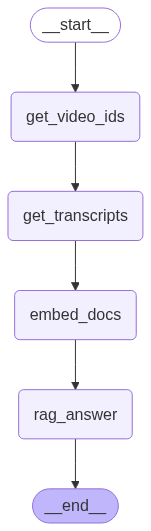

In [45]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## Kick off the Query

In [46]:
query = "What are quantum effects in biology?"
result = app.invoke({"query": query})
print("📥 Final RAG Answer:\n")
print(result["answer"])

Retrieved and filtered Video IDs: ['d1YH1p0bS0Q', '2Fz3zFqLc3E', '1cJPuG1gE0w', '3Z6wH0Z3i0A', '4y3F0Z2bQ1M']
📥 Final RAG Answer:

Quantum effects in biology refer to the influence of quantum mechanics on biological processes. While classical physics typically explains most biological phenomena, certain processes at the molecular level may involve quantum effects. Some areas where quantum biology is being explored include:

1. **Photosynthesis**: Quantum coherence might play a role in the efficient transfer of energy within the photosynthetic complexes of plants and certain bacteria, allowing them to convert sunlight into chemical energy with high efficiency.

2. **Enzyme Catalysis**: Quantum tunneling could be a factor in how enzymes facilitate chemical reactions. This involves particles passing through energy barriers rather than going over them, potentially speeding up reactions.

3. **Olfaction**: The theory of quantum tunneling has been proposed to explain how the sense of smell w